In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from shapely.geometry import Polygon, Point
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
import random
import time

# Load the clusters data
df_clusters = pd.read_csv('https://raw.githubusercontent.com/arvin0711/Kuliah-Soft-Computing/main/EAS_KL_clusterstering.csv')

# Extract main and subcluster centroids
main_cluster_centroids = df_clusters[['MainCluster', 'x', 'y']].groupby('MainCluster').mean().reset_index()
subclusters_centroid = df_clusters[['SubCluster', 'x', 'y']].values
subcluster_number = df_clusters['SubCluster'].values

# Tentukan koordinat dari sudut-sudut batas non-square boundary
boundary_coords = [
    (1.62866, -13.4136),
    (108.826, -119.399),
    (209.65, -179.239),
    (-123.173, -709.999),
    (-225.018, -507.889),
    (-30.0513, -393.164),
    (-111.937, -220.279)
]

# Buat objek Polygon yang mewakili batas non-square boundary
boundary = Polygon(boundary_coords)

# Generate a background that looks like a field with multiple colors
x_min, y_min, x_max, y_max = boundary.bounds
x_field, y_field = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
field_colors = np.random.rand(100, 100, 3)  # Use RGB colors

# Create a mask for the field inside the boundary
field_mask = np.zeros((100, 100, 3))  # Start with all black (0 in all channels)

for i in range(field_colors.shape[0]):
    for j in range(field_colors.shape[1]):
        point = Point(x_field[i, j], y_field[i, j])
        if boundary.contains(point):
            field_mask[i, j] = field_colors[i, j]

# Function to calculate the total cost of a given tour
def calculate_total_cost(tour, distance_matrix, points):
    total_distance = 0
    total_rotation = 0

    # Calculate total distance
    for i in range(len(tour) - 1):
        total_distance += distance_matrix[tour[i], tour[i+1]]

    # Calculate total rotation
    for i in range(len(tour) - 2):
        forward_vector = points[tour[i+1]] - points[tour[i]]
        backward_vector = points[tour[i+2]] - points[tour[i+1]]
        dot_product = np.dot(forward_vector, backward_vector)
        length_forward = np.linalg.norm(forward_vector)
        length_backward = np.linalg.norm(backward_vector)
        cosine_angle = dot_product / (length_forward * length_backward)
        angle_rad = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
        angle_deg = np.degrees(angle_rad)

        if angle_deg < 15:
            angle_deg = 0

        total_rotation += angle_deg

    total_cost = (total_distance * 8.8/4 * 0.6) + (total_rotation / 50 * 0.4)
    return total_cost, total_distance, total_rotation

# Particle Swarm Optimization to solve TSP for a given cluster
def pso_tsp(distance_matrix, points, population_size=40, iterations=300, w=0.9, c1=1.5, c2=2, start_point=None, end_point=None):
    num_points = len(distance_matrix)

    # Initialize population (particles)
    def initialize_population():
        population = []
        for _ in range(population_size):
            tour = list(range(num_points))
            random.shuffle(tour)
            if start_point is not None:
                tour.remove(start_point)
                tour.insert(0, start_point)
            if end_point is not None:
                tour.remove(end_point)
                tour.append(end_point)
            population.append(tour)
        return population

    population = initialize_population()
    velocities = [[] for _ in range(population_size)]
    pbest = population.copy()
    gbest = min(population, key=lambda tour: calculate_total_cost(tour, distance_matrix, points)[0])

    def swap_elements(tour, i, j):
        tour[i], tour[j] = tour[j], tour[i]
        return tour

    def apply_velocity(tour, velocity):
        new_tour = tour.copy()
        for i, j in velocity:
            new_tour = swap_elements(new_tour, i, j)
        return new_tour

    def generate_velocity(tour1, tour2):
        velocity = []
        temp_tour = tour1.copy()
        for i in range(num_points):
            if temp_tour[i] != tour2[i]:
                swap_idx = temp_tour.index(tour2[i])
                velocity.append((i, swap_idx))
                temp_tour = swap_elements(temp_tour, i, swap_idx)
        return velocity

    def update_velocity(velocity, pbest_velocity, gbest_velocity):
        new_velocity = []
        for v in velocity:
            if random.random() < w:
                new_velocity.append(v)
        for pv in pbest_velocity:
            if random.random() < c1:
                new_velocity.append(pv)
        for gv in gbest_velocity:
            if random.random() < c2:
                new_velocity.append(gv)
        return new_velocity

    def apply_constraints(tour):
        if start_point is not None:
            tour.remove(start_point)
            tour.insert(0, start_point)
        if end_point is not None:
            tour.remove(end_point)
            tour.append(end_point)
        return tour

    for _ in range(iterations):
        for i in range(population_size):
            velocity = velocities[i]
            new_velocity_pbest = generate_velocity(population[i], pbest[i])
            new_velocity_gbest = generate_velocity(population[i], gbest)
            velocities[i] = update_velocity(velocity, new_velocity_pbest, new_velocity_gbest)

            population[i] = apply_constraints(apply_velocity(population[i], velocities[i]))
            cost, _, _ = calculate_total_cost(population[i], distance_matrix, points)
            pbest_cost, _, _ = calculate_total_cost(pbest[i], distance_matrix, points)

            if cost < pbest_cost:
                pbest[i] = population[i]

        gbest = min(pbest, key=lambda tour: calculate_total_cost(tour, distance_matrix, points)[0])

    best_cost, best_distance, best_rotation = calculate_total_cost(gbest, distance_matrix, points)

    return gbest, best_cost, best_distance, best_rotation

# Create a distance matrix for all subclusters
all_points = df_clusters[['x', 'y']].values
distance_matrix = np.linalg.norm(all_points[:, None] - all_points[None, :], axis=-1)

# Define combined clusters with start and end points
combined_clusters = {
    '3_5': {'indices': df_clusters[(df_clusters['MainCluster'] == 3) | (df_clusters['MainCluster'] == 5)]['SubCluster'].values - 1, 'start': 19 - 1, 'end': 20 - 1},
    '4_7': {'indices': df_clusters[(df_clusters['MainCluster'] == 4) | (df_clusters['MainCluster'] == 7)]['SubCluster'].values - 1, 'start': 36 - 1, 'end': 37 - 1},
    '1_6': {'indices': df_clusters[(df_clusters['MainCluster'] == 1) | (df_clusters['MainCluster'] == 6)]['SubCluster'].values - 1, 'start': 31 - 1, 'end': 32 - 1},
}

# Define individual clusters with start and end points
individual_clusters = {
    0: {'indices': df_clusters[df_clusters['MainCluster'] == 0]['SubCluster'].values - 1, 'start': 2 - 1, 'end': 5 - 1},
    2: {'indices': df_clusters[df_clusters['MainCluster'] == 2]['SubCluster'].values - 1, 'start': 15 - 1, 'end': 13 - 1},
}

# Optimize combined clusters
optimal_routes = {}
total_cost = 0
total_runtime = 0

for key, cluster_data in combined_clusters.items():
    subcluster_indices = cluster_data['indices']
    subcluster_distance_matrix = distance_matrix[np.ix_(subcluster_indices, subcluster_indices)]

    start_time = time.time()
    best_tour, best_cost, best_distance, best_rotation = pso_tsp(subcluster_distance_matrix, all_points[subcluster_indices], start_point=subcluster_indices.tolist().index(cluster_data['start']), end_point=subcluster_indices.tolist().index(cluster_data['end']))
    end_time = time.time()

    optimal_route = subcluster_indices[best_tour]
    optimal_routes[key] = optimal_route

    total_cost += best_cost
    total_runtime += end_time - start_time

    print(f"Optimal route for Combined Clusters {key}: {optimal_route + 1}")
    print(f"Cost: {best_cost} meters, Distance: {best_distance} meters, Rotation: {best_rotation} degrees")
    print(f"Runtime: {end_time - start_time} seconds\n")

# Optimize individual clusters
for main_cluster, cluster_data in individual_clusters.items():
    subcluster_indices = cluster_data['indices']
    subcluster_distance_matrix = distance_matrix[np.ix_(subcluster_indices, subcluster_indices)]

    start_time = time.time()
    best_tour, best_cost, best_distance, best_rotation = pso_tsp(subcluster_distance_matrix, all_points[subcluster_indices], start_point=subcluster_indices.tolist().index(cluster_data['start']), end_point=subcluster_indices.tolist().index(cluster_data['end']))
    end_time = time.time()

    optimal_route = subcluster_indices[best_tour]
    optimal_routes[main_cluster] = optimal_route

    total_cost += best_cost
    total_runtime += end_time - start_time

    print(f"Optimal route for Main Cluster {main_cluster}: {optimal_route + 1}")
    print(f"Cost: {best_cost} meters, Distance: {best_distance} meters, Rotation: {best_rotation} degrees")
    print(f"Runtime: {end_time - start_time} seconds\n")

# Order of main clusters: combined clusters 3_5 > combined clusters 4_7 > clusters 0 > clusters 2 > combined clusters 1_6
final_order = ['3_5', '4_7', 0, 2, '1_6']
final_route = []

for key in final_order:
    final_route.extend(optimal_routes[key])

Optimal route for Combined Clusters 3_5: [19 18 29 27 28 30 26 17 16 20]
Cost: 684.4400898240247 meters, Distance: 516.547142945885 meters, Rotation: 324.732641932054 degrees
Runtime: 6.082332611083984 seconds

Optimal route for Combined Clusters 4_7: [36 39 38 23 25 24 22 21 40 37]
Cost: 669.0143987177164 meters, Distance: 504.06437233299306 meters, Rotation: 456.17840477070314 degrees
Runtime: 5.8566734790802 seconds

Optimal route for Combined Clusters 1_6: [31 34 33 10  7  9  8  6 35 32]
Cost: 608.5611144729457 meters, Distance: 457.88477769167895 meters, Rotation: 519.1509899911841 degrees
Runtime: 6.500666856765747 seconds

Optimal route for Main Cluster 0: [2 3 4 1 5]
Cost: 272.06572699530165 meters, Distance: 204.8300048427662 meters, Rotation: 211.26507535628502 degrees
Runtime: 1.9978742599487305 seconds

Optimal route for Main Cluster 2: [15 11 14 12 13]
Cost: 289.95221681719335 meters, Distance: 218.3395768516355 meters, Rotation: 217.9969216293073 degrees
Runtime: 1.973758

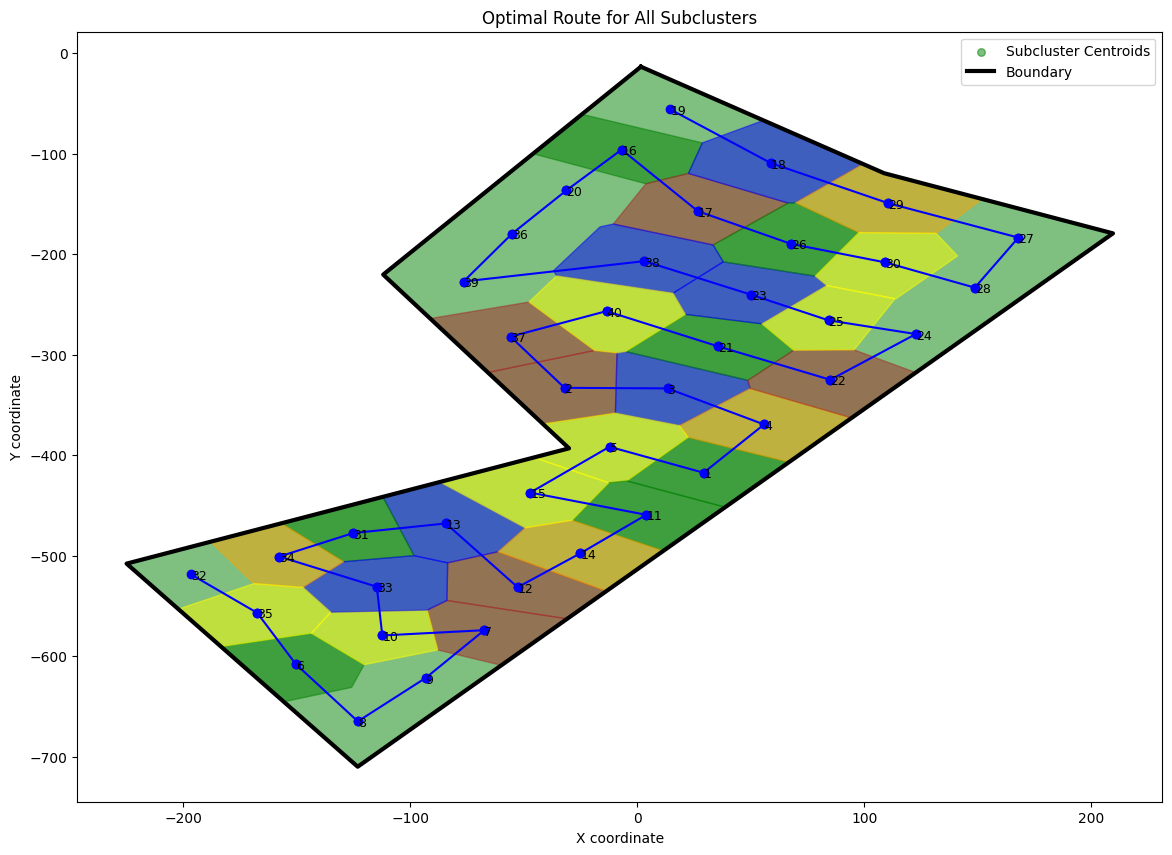

Final Optimal Route:  [19 18 29 27 28 30 26 17 16 20 36 39 38 23 25 24 22 21 40 37  2  3  4  1
  5 15 11 14 12 13 31 34 33 10  7  9  8  6 35 32]
Final Distance:  2106.5770781526594
Total Cost: 2524.033546827182 meters
Total Runtime: 22.411305904388428 seconds


In [ ]:
import matplotlib.colors as mcolors

points = subclusters_centroid[:, 1:]
vor = Voronoi(points)



# Create a plot
plt.figure(figsize=(14, 10))

# Plot a solid color field inside the boundary
field_polygon = plt.Polygon(boundary.exterior.coords, closed=True, color='green', alpha=0.5)
plt.gca().add_patch(field_polygon)

# Plot points
plt.scatter(subclusters_centroid[:, 1], subclusters_centroid[:, 2], c='green', s=30, marker='o', label='Subcluster Centroids', alpha=0.5)

# Annotate subcluster centroids with numbers
for i, (x, y) in enumerate(subclusters_centroid[:, 1:]):
    plt.text(x, y, str(subcluster_number[i]), fontsize=9, ha='left', va='center_baseline', color='black')

# Define custom colors for agriculture theme
colors = ['green', 'brown', 'blue', 'orange', 'yellow']  # Add more colors as needed

# Plot Voronoi regions with agriculture-themed colors
for region in range(len(vor.point_region)):
    region_idx = vor.point_region[region]
    if -1 in vor.regions[region_idx]:  # skip the infinite region
        continue
    polygon = [vor.vertices[i] for i in vor.regions[region_idx]]
    shape = Polygon(polygon)
    if boundary.intersects(shape):
        intersection = boundary.intersection(shape)
        color = colors[region % len(colors)]
        if intersection.geom_type == 'Polygon':
            plt.fill(*zip(*intersection.exterior.coords), color=color, alpha=0.5)
        elif intersection.geom_type == 'MultiPolygon':
            for poly in intersection:
                plt.fill(*zip(*poly.exterior.coords), color=color, alpha=0.5)

# Plot boundary
x, y = boundary.exterior.xy
plt.plot(x, y, color='black', linewidth=3, label='Boundary')

# Example final route plot (replace with your actual route data)
all_points = df_clusters[['x', 'y']].values # Example data
for i in range(len(final_route) - 1):
    plt.plot([all_points[final_route[i]][0], all_points[final_route[i+1]][0]],
             [all_points[final_route[i]][1], all_points[final_route[i+1]][1]],
             'bo-')

# Remove the line connecting the last point back to the start
plt.scatter(all_points[:, 0], all_points[:, 1], c='red', s=30)

plt.title("Optimal Route for All Subclusters")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.legend()
plt.show()

# Convert final route indices to SubCluster numbers
final_route_subcluster = df_clusters.iloc[final_route]['SubCluster'].values

# Print final route
print("Final Optimal Route: ", final_route_subcluster)
print("Final Distance: ", calculate_total_cost(final_route, distance_matrix, all_points)[1])
print(f"Total Cost: {total_cost} meters")
print(f"Total Runtime: {total_runtime} seconds")